This is my first (last?) blog post. I started writing this post as an assignement for Udacity's Data Scientist nanodegree. 

In the end, this exercise was quite interesting and I learned a few tricks on the way. I am aspiring data scientist and I don't have the exultant self-confidence that you can find in even the worst blog posts available online. To make things more interesting, I decided to write as much about the business questions selected for this data as I discuss the very process of inquiring data and all the doubts and questions that arise from it.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [673]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA
from sklearn.feature_extraction import text 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.feature_selection import RFE

In [487]:
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

Each city has three datasets: calendar, listings and reviews. Let's load all of them.

In [5]:
boston_calendar = pd.read_csv('data/boston/calendar.csv')
boston_listings = pd.read_csv('data/boston/listings.csv')
boston_reviews = pd.read_csv('data/boston/reviews.csv')

seattle_calendar = pd.read_csv('data/seattle/calendar.csv')
seattle_listings = pd.read_csv('data/seattle/listings.csv')
seattle_reviews = pd.read_csv('data/seattle/reviews.csv')

The calendar dataframe looks very ordinary. It tells us the id of the property and if it is available or not on a certain day. It also contains the rent price.

In [656]:
boston_calendar.head()

listing_id        date available  price  year month day  occupied
0    12147973  2017-09-05         f    NaN  2017    09  05         1
1    12147973  2017-09-04         f    NaN  2017    09  04         1
2    12147973  2017-09-03         f    NaN  2017    09  03         1
3    12147973  2017-09-02         f    NaN  2017    09  02         1
4    12147973  2017-09-01         f    NaN  2017    09  01         1

The reviews dataset is also quite simple. It basically identifies the property and the reviewer with its comments. Unfortunately I won't touch this dataframe because it is too complicated to get something out of the reviews. Reviews are written in different languages and most of them are speaking well about the place.

When I looked at this dataset I immediately thought that I should do sentiment analysis to assess how well each property fared. However, real life is always more complicated than Newsroom. 

In [657]:
boston_reviews.head()

listing_id       id        date  reviewer_id reviewer_name                                           comments
0     1178162  4724140  2013-05-21      4298113       Olivier  My stay at islam's place was really cool! Good...
1     1178162  4869189  2013-05-29      6452964     Charlotte  Great location for both airport and city - gre...
2     1178162  5003196  2013-06-06      6449554     Sebastian  We really enjoyed our stay at Islams house. Fr...
3     1178162  5150351  2013-06-15      2215611        Marine  The room was nice and clean and so were the co...
4     1178162  5171140  2013-06-16      6848427        Andrew  Great location. Just 5 mins walk from the Airp...

The listings dataframe is much more complex than the previous two.. Although shorter, it contains many more columns with much more information. Let's take a look at one of the entries.

In [670]:
boston_listings.iloc[1,:]

id                                                                            3075044
listing_url                                      https://www.airbnb.com/rooms/3075044
scrape_id                                                              20160906204935
last_scraped                                                               2016-09-07
name                                                Charming room in pet friendly apt
summary                             Charming and quiet room in a second floor 1910...
space                               Small but cozy and quite room with a full size...
description                         Charming and quiet room in a second floor 1910...
experiences_offered                                                              none
neighborhood_overview               The room is in Roslindale, a diverse and prima...
notes                               If you don't have a US cell phone, you can tex...
transit                             Plenty of safe str

There is a lot of information here but some of it is not really useful.

## Business Questions

These are the steps of the CRISP-DM process:


With such rich dataset is easy to come with a few interesting business questions. Here are the ones that I am curious about:

1. Easy one: how occupation, price change with time. Are they correlated?
2. Can we determine what are the main predictors for good reviews?
3. What are the characteristics of the most-sought properties?
4. What are the most popular neighbourhoods? Can we understand why they are popular?
5. Do Airbnb affect renting for local population?

### Occupation and price

The first question that came to my mind was to check occupation and price as a function of time. 

In [9]:
# convert dates to year - month - day
boston_calendar[['year','month','day']] = boston_calendar['date'].str.split(pat='-', expand=True)
seattle_calendar[['year','month','day']] = seattle_calendar['date'].str.split(pat='-', expand=True)
# convert prices from str to float
boston_calendar['price']=pd.to_numeric(boston_calendar['price'].str.strip('$'), errors='coerce')
seattle_calendar['price']=pd.to_numeric(seattle_calendar['price'].str.strip('$'), errors='coerce')

### What is the average price per month?



In [29]:
# get base colors for boston and seattle
base_color = sns.color_palette()[1]
boston1 = sns.color_palette('Paired')[0]
boston2 = sns.color_palette('Paired')[1]
seattle1 = sns.color_palette('Paired')[6]
seattle2 = sns.color_palette('Paired')[7]

No handles with labels found to put in legend.


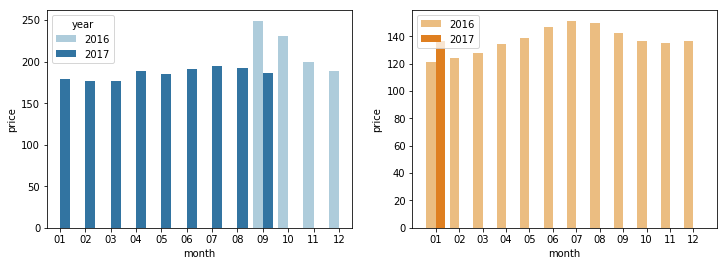

In [505]:
boston_ = boston_calendar[boston_calendar['price'].notnull()].groupby(['year','month']).agg({'price':'mean'}).reset_index()
seattle_ = seattle_calendar[seattle_calendar['price'].notnull()].groupby(['year','month']).agg({'price':'mean'}).reset_index()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
sns.barplot(x='month', y='price', hue='year', data=boston_, ax=ax1, palette=[boston1,boston2]);
plt.legend(loc='upper left');
plt.xlim((-1,12));
sns.barplot(x='month', y='price', hue='year', data=seattle_, ax=ax2, palette=[seattle1,seattle2]);
plt.legend(loc='upper left');
plt.xlim((-1,12));

### How is occupation over time

No handles with labels found to put in legend.


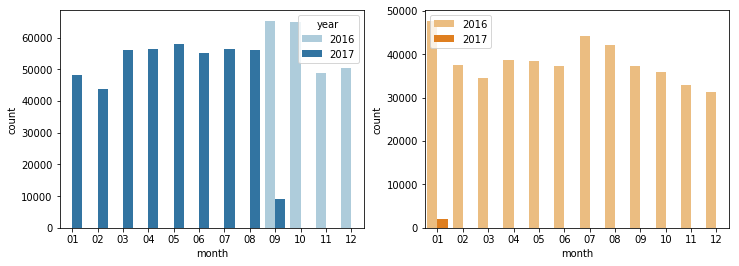

In [511]:
boston_ = boston_calendar[boston_calendar['price'].isnull()].groupby(['year','month']).size().reset_index()
boston_.rename(columns={0:'count'}, inplace=True)
seattle_ = seattle_calendar[seattle_calendar['price'].isnull()].groupby(['year','month']).size().reset_index()
seattle_.rename(columns={0:'count'}, inplace=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
clrs = [boston1 if x==2016 else boston2 for x in boston_.year ]
sns.barplot(x='month', y='count', hue='year', data=boston_, ax=ax1, palette=[boston1,boston2]);
plt.legend(loc='upper left');
sns.barplot(x='month', y='count', hue='year', data=seattle_, ax=ax2, palette=[seattle1,seattle2]);
plt.legend(loc='upper left');

In [512]:
boston_calendar['occupied'] = boston_calendar['available'].apply(lambda x: 1 if x=='f' else 0)
seattle_calendar['occupied'] = seattle_calendar['available'].apply(lambda x: 1 if x=='f' else 0)

In [513]:
boston_rent = boston_calendar.groupby('listing_id').agg({'price':'mean', 'occupied':'sum'}).reset_index()
seattle_rent = seattle_calendar.groupby('listing_id').agg({'price':'mean', 'occupied':'sum'}).reset_index()

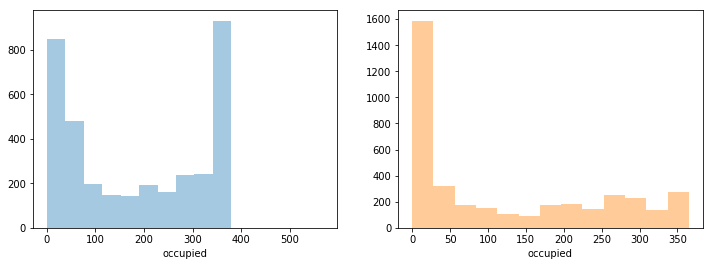

In [519]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
sns.distplot(boston_rent['occupied'], ax=ax1, kde=False, color=boston2);
sns.distplot(seattle_rent['occupied'], ax=ax2, kde=False, color=seattle2);

In [556]:
tmp = seattle_listings.copy()
tmp['host_since'].dropna(inplace=True)
tmp['host_since_year'] = tmp['host_since'].str.split(pat='-', expand=True)[0]
tmp['host_since_year'].dropna(inplace=True)
tmp['host_since_year'].unique()
base_year = pd.to_numeric(tmp['host_since_year'].unique().min())
#seattle_listings['host_since_year'].dropna()
#pd.to_numeric(seattle_listings['host_since_year'].unique().min())
#seattle_listings['host_since_year'].isnull().sum()

### What are the features that makes a unit more attractive

In [603]:
list_columns = ['id',
                'host_since',
                'host_response_rate',
                'host_acceptance_rate',
                'host_is_superhost',
                'host_listings_count',
                'neighbourhood_cleansed',
                'property_type',
                'room_type',
                'accommodates',
                'bathrooms',
                'bedrooms',
                'beds',
                'bed_type',
                'amenities',
                'price',
                'cleaning_fee',
                'minimum_nights',
                'maximum_nights',
                'number_of_reviews',
                'review_scores_rating',
                'review_scores_accuracy',
                'review_scores_cleanliness',
                'review_scores_checkin',
                'review_scores_communication',
                'review_scores_location',
                'review_scores_value',
                'instant_bookable',
                'cancellation_policy',
                'require_guest_profile_picture',
                'require_guest_phone_verification' ]

In [682]:
def listing_pipeline(df, rent_df, list_dummies=[], list_scale=[], list_review=[]):
    
    
    df['host_since_year'] = df['host_since'].str.split(pat='-', expand=True)[0]
    df['host_since_year'].dropna(inplace=True)
    base_year = pd.to_numeric(df['host_since_year'].unique().min())
    df['n_years'] = df['host_since_year'].apply(lambda x: pd.to_numeric(x) - base_year)
    df.drop(['host_since','host_since_year'], axis=1, inplace=True)
    
    df['host_response_rate'] = df['host_response_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
    df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace(r'%', r'.0').astype('float') / 100.0
    df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x: 1 if x=='t' else 0)
    
    df['amenities'] = df['amenities'].str.strip('{,}').str.split(pat=',', expand=True).isnull().sum(axis=1)    
    df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
    df['cleaning_fee'] = df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
    df['instant_bookable'] = df['instant_bookable'].apply(lambda x: 0 if x=='f' else 1)
    
    #I am not sure if these two are relevant but I added them anyway. It might catch customers that are more privacy-oriented.
    df['require_guest_profile_picture'] = df['require_guest_profile_picture'].apply(lambda x: 0 if x=='f' else 1)
    df['require_guest_phone_verification'] = df['require_guest_phone_verification'].apply(lambda x: 0 if x=='f' else 1)

   
    #Done with choosing columns. Now let's take a look at the missing values.
    
    df['host_response_rate'] = df['host_response_rate'].fillna(0.0)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].fillna(0.0)
    
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    df['bathrooms'] = imp_median.fit_transform(df[['bathrooms']])
    df['bedrooms'] = imp_median.fit_transform(df[['bedrooms']])
    df['beds'] = imp_median.fit_transform(df[['beds']])
    
    imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df['property_type'] = imp_mf.fit_transform(df[['property_type']])
    
   
    
    df[list_review] = imp_median.fit_transform(df[list_review])
    df['review_agg'] = df[list_review].mean(axis=1)
    list_scale.extend(list_review)
    df['cleaning_fee'] = df['cleaning_fee'].fillna(0.0)
    
    df['review_agg'] = df[list_review].mean(axis=1)
    
    df_dummies = pd.get_dummies(df[list_dummies], drop_first=True)
    df2 = pd.merge(df, df_dummies, left_index=True, right_index=True)
    df2.drop(list_dummies,axis=1, inplace=True)
    
    list_scale.append('review_agg')
    
    #df2.drop('price', axis=1, inplace=True)
    rent_df.drop('price', axis=1, inplace=True)
    
    list_scale.extend(rent_df.columns.values.tolist())
    list_scale.remove('listing_id')
    #list_scale.remove('occupied')
    
    df3 = pd.merge(rent_df, df2, left_on='listing_id', right_on='id', how='left')
    
    df3['avg_nights'] = (df3['maximum_nights'] + df3['minimum_nights']) / 2.0
    df3['n_rent'] = df3['occupied'] / df3['avg_nights']
    #df3.drop(['avg_nights','occupied'], axis=1, inplace=True)
    df3.drop(['avg_nights'], axis=1, inplace=True)
    
    
    #df3.drop(['listing_id','maximum_nights','minimum_nights'], axis=1, inplace=True)
    #list_scale.remove('maximum_nights')
    #list_scale.remove('minimum_nights')
    df3.drop(['listing_id'], axis=1, inplace=True)
    
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    df3[list_scale] = scaler.fit_transform(df3[list_scale])
    
    return df3

In [683]:
list_dummies = ['room_type','bed_type','cancellation_policy','neighbourhood_cleansed','property_type']
list_scale = ['accommodates','bathrooms','bedrooms','beds','price','cleaning_fee','minimum_nights', 
                   'maximum_nights', 
                   'number_of_reviews','amenities','host_listings_count','review_scores_rating']
list_review = ['review_scores_accuracy',
                   'review_scores_cleanliness',
                   'review_scores_checkin',
                   'review_scores_communication',
                   'review_scores_location',
                   'review_scores_value']
list_scale.extend(list_review)
    
bldf = listing_pipeline(boston_listings[list_columns].copy(), boston_rent.copy(), list_dummies, list_scale, list_review)
sldf = listing_pipeline(seattle_listings[list_columns].copy(), seattle_rent.copy(), list_dummies, list_scale, list_review)

/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/brunom/.miniconda2/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [597]:
bldf[['occupied','review_agg','n_rent']].corr()

occupied  review_agg    n_rent
occupied    1.000000    0.108954  0.267128
review_agg  0.108954    1.000000  0.071865
n_rent      0.267128    0.071865  1.000000

In [598]:
sldf[['occupied','review_agg','n_rent']].corr()

occupied  review_agg    n_rent
occupied    1.000000    0.062831  0.362473
review_agg  0.062831    1.000000  0.040968
n_rent      0.362473    0.040968  1.000000

That's very interesting. Reviews are not correlated with occupation or number of rents.

In [629]:
bldf2 = bldf.copy()
bldf2.drop(['id','occupied','minimum_nights','maximum_nights'], axis=1, inplace=True)
bldf2.drop(list_review, axis=1, inplace=True)
bldf2.drop('review_agg', axis=1, inplace=True)
target='review_scores_rating'
y = bldf2[target]
X = bldf2.drop([target],axis=1)
ab_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), random_state=34, n_estimators = 200)
ab_reg.fit(X_train, y_train)
y_preds = ab_reg.predict(X_test)
r2_score(y_test,y_preds)

0.3904458959410352

In [684]:
# adaboost classifier with target as n_rent
bldf2 = bldf.copy()
bldf2.drop(['id','occupied','minimum_nights','maximum_nights'], axis=1, inplace=True)
#bldf2['log_review'] = np.log(1+bldf2['n_rent'])
target = 'review_scores_rating'
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.drop(['review_scores_rating'], axis=1, inplace=True)
bldf2.drop(target, axis=1, inplace=True)
bldf2.drop(list_review, axis=1, inplace=True)
bldf2.drop('review_agg', axis=1, inplace=True)
#bldf2.score.value_counts()
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
#ab_clf = AdaBoostClassifier(learning_rate=0.2, random_state=34, n_estimators = 200)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
y_preds = ab_clf.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(confusion_matrix(y_test,y_preds))
features = pd.Series(data=ab_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
print(features[:10])

0.5785472972972973
[[330  36  59  50]
 [ 54  43  88  30]
 [ 32  24 203   5]
 [ 62   3  56 109]]
number_of_reviews                       0.44
host_is_superhost                       0.20
host_listings_count                     0.16
amenities                               0.06
price                                   0.06
neighbourhood_cleansed_Jamaica Plain    0.02
n_years                                 0.02
cleaning_fee                            0.02
n_rent                                  0.02
bed_type_Couch                          0.00
dtype: float64


In [ ]:
parameters = {'learning_rate': np.arange(0.1,1.1,0.1), 'n_estimators':[100, 200, 300, 400, 500, 1000]}
grid_clf = GridSearchCV(ab_clf, parameters, cv=5)
grid_clf.fit(X_train, y_train)
grid_clf.best_score_

In [561]:
# we drop all reviews except review_agg 
list_review.append('review_scores_rating')
bldf.drop(list_review, axis=1, inplace=True)
sldf.drop(list_review, axis=1, inplace=True)

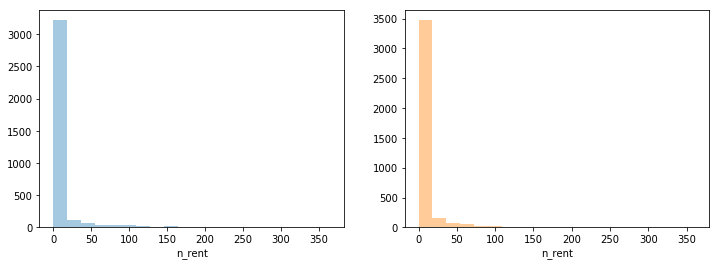

In [568]:
#bldf.n_rent.plot.hist()
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
sns.distplot(bldf['n_rent'], ax=ax1, kde=False, color=boston2, bins=20);
sns.distplot(sldf['n_rent'], ax=ax2, kde=False, color=seattle2, bins=20);

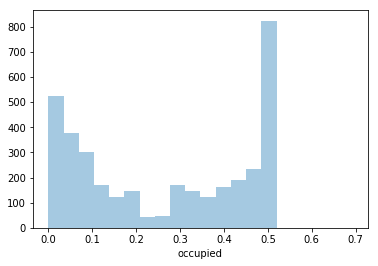

In [578]:
sns.distplot(np.log(1+bldf['occupied']), kde=False, color=boston2, bins=20);

In [583]:
# adaboost classifier with target as log occupied
bldf2 = bldf.drop(['id','n_rent','minimum_nights','maximum_nights'], axis=1).copy()
bldf2['log_rent'] = np.log(1+bldf2['occupied'])
target = 'log_rent'
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop('occupied', axis=1, inplace=True)
bldf2.drop(target, axis=1, inplace=True)
#bldf2.score.value_counts()
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_clf = AdaBoostClassifier(learning_rate=1.2, random_state=34, n_estimators = 2000)
#ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
y_preds = ab_clf.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(confusion_matrix(y_test,y_preds))
features = pd.Series(data=ab_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
print(features[:10])

0.43327702702702703
[[123  59  82  25]
 [ 67  90  85  34]
 [ 54  69 126  50]
 [ 46  40  60 174]]
price                   0.2275
number_of_reviews       0.1560
host_acceptance_rate    0.0985
host_listings_count     0.0835
cleaning_fee            0.0805
amenities               0.0690
review_agg              0.0515
host_response_rate      0.0390
accommodates            0.0260
n_years                 0.0205
dtype: float64


In [577]:
# adaboost classifier with target as n_rent
bldf2 = bldf.drop(['id','occupied','minimum_nights','maximum_nights'], axis=1).copy()
bldf2['log_rent'] = np.log(1+bldf2['n_rent'])
target = 'log_rent'
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop('n_rent', axis=1, inplace=True)
bldf2.drop(target, axis=1, inplace=True)
#bldf2.score.value_counts()
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
#ab_clf = AdaBoostClassifier(learning_rate=0.2, random_state=34, n_estimators = 200)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
y_preds = ab_clf.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(confusion_matrix(y_test,y_preds))
features = pd.Series(data=ab_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
print(features[:10])

0.4197635135135135
[[133  49   9 107]
 [ 59  91  25 126]
 [ 17  40  23 152]
 [ 50  35  18 250]]
host_listings_count              0.185
number_of_reviews                0.075
host_acceptance_rate             0.070
cleaning_fee                     0.070
price                            0.070
amenities                        0.050
review_agg                       0.040
room_type_Entire home/apt        0.035
host_response_rate               0.030
neighbourhood_cleansed_Fenway    0.025
dtype: float64


In [503]:
parameters = {'learning_rate': np.arange(0.1,1.1,0.1), 'n_estimators':[100, 200, 300, 400, 500, 1000]}
grid_clf = GridSearchCV(ab_clf, parameters, cv=5)
grid_clf.fit(X_train, y_train)
grid_clf.best_score_

0.44773011245314454

In [691]:
# adaboost classifier with target as review_agg
target='review_agg'
bldf2 = bldf.drop(['id'], axis=1)
#qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.drop(target, axis=1, inplace=True)
#bldf2.score.value_counts()
bldf2.drop(list_review, axis=1, inplace=True)
bldf2.drop('review_scores_rating', axis=1, inplace=True)
y = bldf2[target]
X = bldf2.drop([target],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
lasso = Lasso(normalize=True, alpha=1.0)
lasso.fit(X_train, y_train)
y_preds = lasso.predict(X_test)
print(r2_score(y_test, y_preds))

-0.0016063814522799813


In [692]:
target='n_rent'
bldf2 = bldf.drop(['id'], axis=1)
#qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.drop(target, axis=1, inplace=True)
#bldf2.score.value_counts()
bldf2.drop(list_review, axis=1, inplace=True)
bldf2.drop('review_scores_rating', axis=1, inplace=True)
y = bldf2[target]
X = bldf2.drop([target],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
lasso = Lasso(normalize=True, alpha=1.0)
lasso.fit(X_train, y_train)
y_preds = lasso.predict(X_test)
print(r2_score(y_test, y_preds))

-0.0008345186947142924


In [681]:
# adaboost classifier with target as review_agg
target='review_agg'
bldf2 = bldf.drop(['id','n_rent'], axis=1)
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop(target, axis=1, inplace=True)
#bldf2.score.value_counts()
bldf2.drop(list_review, axis=1, inplace=True)
bldf2.drop('review_scores_rating', axis=1, inplace=True)
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
#ab_clf = AdaBoostClassifier(learning_rate=0.2, random_state=34, n_estimators = 200)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
y_preds = ab_clf.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(confusion_matrix(y_test,y_preds))
features = pd.Series(data=ab_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
print(features[:10])

0.6275337837837838
[[100  86  63]
 [ 57 142 118]
 [ 35  82 501]]
number_of_reviews                 0.20
host_is_superhost                 0.16
host_listings_count               0.16
price                             0.12
amenities                         0.08
host_response_rate                0.08
neighbourhood_cleansed_Roxbury    0.04
occupied                          0.04
bathrooms                         0.02
maximum_nights                    0.02
dtype: float64


In [669]:
# adaboost classifier with target as review_agg
sldf2 = sldf.copy()
sldf2.drop('review_scores_rating', axis=1, inplace=True)
sldf2.dropna(inplace=True)
target='review_agg'
sldf2.drop(['id','n_rent'], axis=1, inplace=True)
qt = sldf2[target].quantile([.25,.50,.75]).values.tolist()
sldf2['score'] = sldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
sldf2.drop(target, axis=1, inplace=True)
#bldf2.score.value_counts()
sldf2.drop(list_review, axis=1, inplace=True)

y = sldf2['score']
X = sldf2.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
#ab_clf = AdaBoostClassifier(learning_rate=0.2, random_state=34, n_estimators = 200)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
y_preds = ab_clf.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(confusion_matrix(y_test,y_preds))
features = pd.Series(data=ab_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
print(features[:10])

0.5325396825396825
[[ 83  77   0  38]
 [ 65 123   0  75]
 [ 39  67   0  91]
 [ 60  76   1 465]]
host_is_superhost                             0.22
number_of_reviews                             0.18
host_listings_count                           0.14
host_response_rate                            0.10
amenities                                     0.08
occupied                                      0.04
bathrooms                                     0.04
price                                         0.04
bed_type_Real Bed                             0.02
neighbourhood_cleansed_University District    0.02
dtype: float64


In [590]:
ab_clf.estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=165621153, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=840799354, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_lea

In [593]:
parameters = {'learning_rate': np.arange(0.05,1.2,0.05), 'n_estimators':[50, 100, 150, 200, 250, 300, 350, 400, 500, 1000]}
grid_clf = GridSearchCV(ab_clf, parameters, cv=5)
grid_clf.fit(X_train, y_train)
grid_clf.best_score_

0.6434818825489379

In [631]:
best_ab = grid_clf.best_estimator_

In [ ]:
target='n_rent'
bldf2 = bldf.drop(['id'], axis=1)
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop(target, axis=1, inplace=True)
bldf2.drop(list_review, axis=1, inplace=True)
bldf2.drop('review_scores_rating', axis=1, inplace=True)
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)

for i in range(2,X.shape[1]):
    rfe_ab = RFE(best_ab, n_features_to_select=i)
    rfe_ab = rfe_ab.fit(X, y)
    X_red = X.iloc[:,rfe_ab.support_].copy()
    X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33, shuffle=True)
    best_ab.fit(X_train, y_train)
    y_preds = best_ab.predict(X_test)
    print('i: {}, acc: {}'.format(i, accuracy_score(y_test, y_preds)))

    
    lasso = Lasso(normalize=True, alpha=1.0)
    rfe_lasso = RFE(lasso, n_features_to_select=i)
    rfe_lasso = rfe_lasso.fit(X, y)
    X_red = X.iloc[:,rfe_lasso.support_].copy()
    X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33, shuffle=True)
    lasso.fit(X_train, y_train)
    y_preds = lasso.predict(X_test)
    print('i: {}, acc: {}'.format(i, r2_score(y_test, y_preds)))
    
    #print(confusion_matrix(y_test,y_preds))
    #features = pd.Series(data=best_ab.feature_importances_, index = X_red.columns).sort_values(ascending=False)
    #print(features[:10])

In [694]:
target='review_agg'
bldf2 = bldf.drop(['id'], axis=1)
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop(target, axis=1, inplace=True)
bldf2.drop(list_review, axis=1, inplace=True)
bldf2.drop('review_scores_rating', axis=1, inplace=True)
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)

for i in range(2,X.shape[1]):
    rfe_ab = RFE(best_ab, n_features_to_select=i)
    rfe_ab = rfe_ab.fit(X, y)
    X_red = X.iloc[:,rfe_ab.support_].copy()
    X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33, shuffle=True)
    best_ab.fit(X_train, y_train)
    y_preds = best_ab.predict(X_test)
    print('i: {}, acc: {}'.format(i, accuracy_score(y_test, y_preds)))

    
    lasso = Lasso(normalize=True, alpha=1.0)
    rfe_lasso = RFE(lasso, n_features_to_select=i)
    rfe_lasso = rfe_lasso.fit(X, y)
    X_red = X.iloc[:,rfe_lasso.support_].copy()
    X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33, shuffle=True)
    lasso.fit(X_train, y_train)
    y_preds = lasso.predict(X_test)
    print('i: {}, acc: {}'.format(i, r2_score(y_test, y_preds)))
    
    #print(confusion_matrix(y_test,y_preds))
    #features = pd.Series(data=best_ab.feature_importances_, index = X_red.columns).sort_values(ascending=False)
    #print(features[:10])


i: 2, acc: 0.5329391891891891
i: 2, acc: -0.0012309751145134218
i: 3, acc: 0.6021959459459459
i: 3, acc: -0.0001549115521664035
i: 4, acc: 0.5945945945945946
i: 4, acc: -0.004786892567024026
i: 5, acc: 0.612331081081081
i: 5, acc: -0.00015153729412364925
i: 6, acc: 0.6402027027027027
i: 6, acc: -0.003668305828223639
i: 7, acc: 0.6030405405405406
i: 7, acc: -0.002401952174587718
i: 8, acc: 0.6511824324324325
i: 8, acc: -2.184520353365471e-05
i: 9, acc: 0.6216216216216216
i: 9, acc: -3.226319476223871e-05
i: 10, acc: 0.6326013513513513
i: 10, acc: -3.205774349490653e-05
i: 11, acc: 0.6258445945945946
i: 11, acc: -0.0014110913963998328
i: 12, acc: 0.6638513513513513
i: 12, acc: -0.00023544830643462689
i: 13, acc: 0.6444256756756757
i: 13, acc: -0.0007598491840219435
i: 14, acc: 0.6444256756756757
i: 14, acc: -0.006593401472447802
i: 15, acc: 0.652027027027027
i: 15, acc: -0.0017480163406138338
i: 16, acc: 0.6402027027027027
i: 16, acc: -0.0020915859563046535
i: 17, acc: 0.6427364864864865

In [650]:
X.shape

(3585, 69)

In [651]:
X.iloc[:,rfe_ab.support_].shape

(3585, 34)

In [643]:
rfe_data = rfe_ab.transform(X)

In [637]:
cutoffs=[5000, 3500, 2500, 1000, 100, 50, 30, 25]
target = 'review_agg'
    
bldf2 = bldf.drop(['id','n_rent'], axis=1)
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop(target, axis=1, inplace=True)
bldf2.drop(list_review, axis=1, inplace=True)
bldf2.drop('review_scores_rating', axis=1, inplace=True)
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)

for c in cutoffs:
    X_red = X.iloc[:, np.where((X.sum()>c)==True)[0]]
    X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33, shuffle=True)
#ab_clf = AdaBoostClassifier(learning_rate=0.2, random_state=34, n_estimators = 200)
    ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
    ab_clf.fit(X_train, y_train)
    y_preds = ab_clf.predict(X_test)
    print('c:{}, score:{}'.format(c, accuracy_score(y_test, y_preds)))
    

c:5000, score:0.5202702702702703
c:3500, score:0.5304054054054054
c:2500, score:0.5472972972972973
c:1000, score:0.5506756756756757
c:100, score:0.6444256756756757
c:50, score:0.6342905405405406
c:30, score:0.6241554054054054
c:25, score:0.6165540540540541


### Bag of words

Let's check the overviews written by the owners. It might give us some sense about the "vibe" of the region. However, I don't expect to find anything like "wow, this region is really sketchy". 

The first thing we notice is that 40% of the overviews are missing.

### PCA

We would like to know what are the characteristics of a property that is in high demand. Following the same approach we used above, we define again a four-star classification this time based on the number of times the unit was rented.

In [506]:
bldf2 = bldf.drop(['id'], axis=1).copy()

#target='review_agg'
target='n_rent'
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
score_target = pd.Series(bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1))) )

bldf2.drop(['n_rent','occupied','review_agg'], axis=1, inplace=True)

In [507]:
def pca(df, n_components):
    '''
    Generates PCA model
    
    INPUT: df - scaled dataframe
           n_components - number of components for the model
           
    OUTPUT: pca_model - PCA object
            var_pca - dataframe with components and explained variances
            X_pca - numpy array with transformed data
    '''
    pca_model = PCA(n_components)
    X_pca = pca_model.fit_transform(df)
    components = pd.DataFrame(np.round(pca_model.components_, 4), columns = df.keys())
    ratios = pca_model.explained_variance_ratio_.reshape(len(pca_model.components_),1)
    dimensions = ['Dim {}'.format(i) for i in range(len(pca_model.components_))]
    components.index = dimensions
    variance_ratios = pd.DataFrame(np.round(ratios,4), columns=['Explained_Variance'])
    variance_ratios.index = dimensions
    var_pca = pd.concat([variance_ratios, components], axis=1)
    
    return pca_model, var_pca, X_pca

In [508]:
pca_model, var_pca, X_pca = pca(bldf2, 10)

In [537]:
var_pca.head()

Explained_Variance  host_response_rate  host_acceptance_rate  host_is_superhost  host_listings_count  accommodates  bathrooms  bedrooms    beds  amenities   price  cleaning_fee  minimum_nights  maximum_nights  number_of_reviews  instant_bookable  require_guest_profile_picture  require_guest_phone_verification  n_years  room_type_Entire home/apt  room_type_Private room  room_type_Shared room  bed_type_Airbed  bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  bed_type_Real Bed  cancellation_policy_flexible  cancellation_policy_moderate  cancellation_policy_strict  cancellation_policy_super_strict_30  neighbourhood_cleansed_Allston  neighbourhood_cleansed_Back Bay  neighbourhood_cleansed_Bay Village  neighbourhood_cleansed_Beacon Hill  neighbourhood_cleansed_Brighton  neighbourhood_cleansed_Charlestown  neighbourhood_cleansed_Chinatown  neighbourhood_cleansed_Dorchester  neighbourhood_cleansed_Downtown  neighbourhood_cleansed_East Boston  neighbourhood_cleansed_Fenway  neighbourhood_cleansed_Hyde Park  neighbourhood_cleansed_Jamaica Plain  neighbourhood_cleansed_Leather District  neighbourhood_cleansed_Longwood Medical Area  neighbourhood_cleansed_Mattapan  neighbourhood_cleansed_Mission Hill  neighbourhood_cleansed_North End  neighbourhood_cleansed_Roslindale  neighbourhood_cleansed_Roxbury  neighbourhood_cleansed_South Boston  neighbourhood_cleansed_South Boston Waterfront  neighbourhood_cleansed_South End  neighbourhood_cleansed_West End  neighbourhood_cleansed_West Roxbury  property_type_Apartment  property_type_Bed & Breakfast  property_type_Boat  property_type_Camper/RV  property_type_Condominium  property_type_Dorm  property_type_Entire Floor  property_type_Guesthouse  property_type_House  property_type_Loft  property_type_Other  property_type_Townhouse  property_type_Villa
Dim 0              0.4770              0.0186               -0.0033             0.0102               0.0140        0.0073     0.0022    0.0073  0.0026     0.0024  0.0015        0.0199          0.0005          0.0002             0.0125           -0.0170                         0.0137                            0.0607  -0.9934                     0.0350                 -0.0308                -0.0043          -0.0010         -0.0007         -0.0015                 -0.0001             0.0032                       -0.0557                        0.0067                      0.0139                               0.0351                         -0.0095                           0.0091                             -0.0004                              0.0017                          -0.0104                              0.0015                           -0.0015                             0.0022                           0.0055                             -0.0023                        -0.0090                           -0.0027                                0.0111                                   0.0002                                       -0.0006                          -0.0019                              -0.0017                            0.0022                             0.0008                          0.0057                              -0.0038                                         -0.0029                            0.0067                           0.0011                              -0.0012                   0.0073                         0.0018              0.0023                  -0.0002                    -0.0070             -0.0002                     -0.0002                   -0.0002              -0.0011              0.0006               0.0016                  -0.0047              -0.0001
Dim 1              0.0933             -0.0406                0.0134             0.0334              -0.1009       -0.0736    -0.0041   -0.0455 -0.0254     0.0443 -0.0198       -0.1150         -0.0013         -0.0003             0.0136            0.0220                         0.0100                           -0.0139  -0.0635                    -0.5784          

In [538]:
def pca_analysis(var_pca, component):
    '''
    Generate a dataframe with the attributes listed by weight for
    a given component.
    
    INPUT: var_pca - dataframe with the PCA output
           component - number of the component
           
    OUTPUT: dataframe with attributes and weights
    '''
    
    df = pd.DataFrame(var_pca.iloc[component,:].sort_values(axis=0, ascending=False))
    df['attribute {}'.format(component)] = df.index
    df.set_index(np.arange(var_pca.shape[1]), inplace=True)

    return df

In [539]:
list_df = []
var_pca.drop('Explained_Variance', axis=1, inplace=True)
for i in range(10):
    list_df.append(pca_analysis(var_pca, i))
var_comp = pd.concat([x for x in list_df],axis=1)

In [540]:
var_comp.head()

Dim 0                          attribute 0   Dim 1                        attribute 1   Dim 2                 attribute 2   Dim 3                   attribute 3   Dim 4                   attribute 4   Dim 5                   attribute 5   Dim 6                      attribute 6   Dim 7                           attribute 7   Dim 8                          attribute 8   Dim 9                           attribute 9
0  0.0607     require_guest_phone_verification  0.5702             room_type_Private room  0.6174  cancellation_policy_strict  0.7486  cancellation_policy_moderate  0.4278           property_type_House  0.2221  cancellation_policy_moderate  0.8671                 instant_bookable  0.6243                     host_is_superhost  0.5666     neighbourhood_cleansed_South End  0.4759             property_type_Condominium
1  0.0351  cancellation_policy_super_strict_30  0.2227                property_type_House  0.2950        host_acceptance_rate  0.2506            host_response_rate  0.3331     room_type_Entire home/apt  0.2008    cancellation_policy_strict  0.1278     cancellation_policy_moderate  0.3881  neighbourhood_cleansed_Jamaica Plain  0.4275            property_type_Condominium  0.4552  neighbourhood_cleansed_Jamaica Plain
2  0.0350            room_type_Entire home/apt  0.2185       cancellation_policy_flexible  0.2885          host_response_rate  0.2407          host_acceptance_rate  0.2332  cancellation_policy_flexible  0.1027           property_type_House  0.1277   neighbourhood_cleansed_Allston  0.2866      neighbourhood_cleansed_South End  0.0876    neighbourhood_cleansed_Dorchester  0.2478       neighbourhood_cleansed_Back Bay
3  0.0199                         cleaning_fee  0.0945       cancellation_policy_moderate  0.2291         property_type_House  0.0924             host_is_superhost  0.1703     property_type_Condominium  0.0754        room_type_Private room  0.0530        property_type_Condominium  0.0740            cancellation_policy_strict  0.0851                 host_acceptance_rate  0.1682         neighbourhood_cleansed_Fenway
4  0.0186                   host_response_rate  0.0784  neighbourhood_cleansed_Dorchester  0.1465            instant_bookable  0.0825     room_type_Entire home/apt  0.0846                      bedrooms  0.0533           host_listings_count  0.0446  neighbourhood_cleansed_Brighton  0.0623               property_type_Apartment  0.0809  neighbourhood_cleansed_South Boston  0.1395                   host_listings_count

In [481]:
n_clusters = 10
k_model_final = KMeans(n_clusters = n_clusters, random_state=34).fit(X_pca)
k_score_final = k_model_final.score(X_pca)
k_score_final

-5563.276564928061

In [482]:
# generate dataframe with partial populations in each cluster
k_pop = pd.DataFrame(np.unique(k_model_final.labels_), columns=['cluster'])
k_pop['population'] = np.bincount(k_model_final.labels_) / k_model_final.labels_.shape[0]

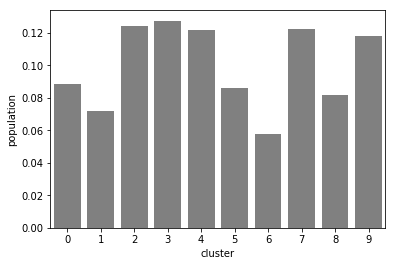

In [483]:
sns.barplot(x = 'cluster', y = 'population', data=k_pop, color='gray')

In [484]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = bldf2.index.values
cluster_map['score']=score_target
cluster_map['cluster'] = k_model_final.labels_

In [485]:
cluster_map[cluster_map['score']==4]['cluster'].value_counts()

2    197
7    154
0    146
4    141
8    100
3     96
5     80
1     73
6     59
9     54
Name: cluster, dtype: int64

In [356]:
# 40% of neighborhood overviews missing
boston_listings['neighborhood_overview'].isnull().mean()

0.3947001394700139

We take the rest and convert to a new dataframe

In [398]:
bl_no = boston_listings.loc[boston_listings['neighborhood_overview'].notnull(), 
                            ['host_neighbourhood','neighborhood_overview']]
bl_no.head()

host_neighbourhood                              neighborhood_overview
0         Roslindale  Roslindale is quiet, convenient and friendly. ...
1         Roslindale  The room is in Roslindale, a diverse and prima...
2         Roslindale  The LOCATION: Roslindale is a safe and diverse...
3                NaN  Roslindale is a lovely little neighborhood loc...
4         Roslindale  I love the proximity to downtown, the neighbor...

In [399]:
bl_no.shape

(2170, 2)

In [401]:
bl_no_grouped = bl_no.groupby('host_neighbourhood').agg({'neighborhood_overview':'sum'}).reset_index()
bl_no_grouped.head()

host_neighbourhood                              neighborhood_overview
0   Allston-Brighton  The Back Bay neighborhood runs along the Charl...
1           Back Bay  Living at The Longwood Apartments, residents w...
2        Beacon Hill  Great location! Walk to the Longwood Medical A...
3           Belváros  Conveniently located across from premier shopp...
4        Benton Park  Once called "The Eden of America" by a visitor...

In [402]:
bl_no_grouped.shape

(46, 2)

In [403]:
my_stop_words=['boston']
stop_words = text.ENGLISH_STOP_WORDS.union(my_stop_words)

In [414]:
list_msg=[]
for i in range(bl_no_grouped.shape[0]):
    count_vect = CountVectorizer(stop_words=stop_words, ngram_range=(2,2))
    X_train = count_vect.fit_transform([bl_no_grouped.loc[i,'neighborhood_overview']])
    lda = LatentDirichletAllocation(n_components=1,random_state=34)
    lda.fit(X_train) 
    feature_names = count_vect.get_feature_names()
    for idx, topic in enumerate(lda.components_):
        message = " ".join([feature_names[i] for i in topic.argsort()[:-8 :-1]])
    list_msg.extend([message])

In [415]:
bl_no_grouped['message']=list_msg

In [416]:
list_msg

['harvard square walking distance restaurants bars close harvard easy access grocery store minute walk',
 'newbury street beacon hill charles river walking distance prudential center minute walk south end',
 'beacon hill public transportation newbury street steps public financial district south end mall newbury',
 'water shuttle silver line shopping dining premier shopping nightlife easy major highways located premier',
 'jamaica pond jamaica plain forrest hills dining spots doyle pub earth jamaica eden america',
 'walkable attractions walk food attractions mgh center commons charles river charles street commons gardens',
 'walking access conveniences borough folks looking favorite neighborhoods excellent safe enjoying conveniences easy walking',
 'right street lounges surrounding leisurely traveling plenty restaurants bike rentals street chinatown hr diner',
 'waterfront park park home home bruins home red garden home fenway park faneuil hall',
 'bunker hill navy yard hill monument fr

In [486]:
bl_no_grouped[['host_neighbourhood','message']]

host_neighbourhood                                            message
0            Allston-Brighton  harvard square walking distance restaurants ba...
1                    Back Bay  newbury street beacon hill charles river walki...
2                 Beacon Hill  beacon hill public transportation newbury stre...
3                    Belváros  water shuttle silver line shopping dining prem...
4                 Benton Park  jamaica pond jamaica plain forrest hills dinin...
5              Bernal Heights  walkable attractions walk food attractions mgh...
6                   Brookline  walking access conveniences borough folks look...
7                   Cambridge  right street lounges surrounding leisurely tra...
8   Central Business District  waterfront park park home home bruins home red...
9                 Charlestown  bunker hill navy yard hill monument freedom tr...
10                    Chelsea  charles street walking distance eat drink mass...
11              Chestnut Hill  location location 走路2 minutes有shopping desirab...
12                  Chinatown  medical center great neighborhoods min drive c...
13            Coolidge Corner  vibe lots foods ma away art best sushi biggest...
14                  Coral Way  water shuttle establishments walk adjacent sil...
15                 Dorchester  beautiful victorian walking distance red line ...
16                   Downtown  outside door market place faneuil hall haymark...
17          Downtown Crossing  downtown crossing beacon hill prudential cente...
18                East Boston  minute walk logan airport blue line block away...
19                East Harlem  welcoming neighbors warm welcoming quiet area ...
20             Fenway/Kenmore  university mi center mi fenway park museum fin...
21         Financial District  north end waterfront aquarium subway lines fan...
22          Flatiron District  night spots walking distance fantastic restaur...
23                Gay Village  south end tree lined walking distance young pr...
24          Government Center  walk bike hospital chinatown hall market golde...
25                  Hyde Park  hyde park minute walk family friendly neighbor...
26              Jamaica Plain  jamaica plain jamaica pond arnold arboretum mi...
27           Leather District  minute walk south station 10 minute station ta...
28            Los Altos Hills  unique historic significant historic neighborh...
29                     Malden  unbelievably close train station logan interna...
30                   Mattapan  states diverse establishments covering comfort...
31                    Medford  south end restaurants shops copley square popu...
32                Miami Beach  water shuttle establishments walk adjacent sil...
33           Mission District  school campus safe awesome harvard business cl...
34               Mission Hill  mission hill minute walk fine arts museum fine...
35                     Newton  navy yard minutes away general hospital yard w...
36                  North End  north end paul revere italian restaurants fane...
37                 Roslindale  arnold arboretum minute walk walking distance ...
38                    Roxbury  fort hill walk away south end min walk highlan...
39                 Somerville  uber ride short walk young families italian me...
40                South Beach  restaurants bars samuel adams younger crowd di...
41               South Boston  walking distance minute walk restaurants bars ...
42                  South End  south end minute walk walking distance copley ...
43           Theater District  bay village public garden charles river copley...
44                   West End  south end new england endless traces area harv...
45               West Roxbury  west roxbury quiet friendly walking distance f...

In [247]:
# adaboost classifier with target as occupied
bldf2 = bldf.drop(['id','n_rent'], axis=1)
qt = bldf2['occupied'].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2['occupied'].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop('occupied', axis=1, inplace=True)
#bldf2.score.value_counts()
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
#ab_clf = AdaBoostClassifier(learning_rate=0.2, random_state=34, n_estimators = 200)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
y_preds = ab_clf.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(confusion_matrix(y_test,y_preds))
features = pd.Series(data=ab_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
print(features[:10])

0.47550675675675674
[[115  81  57  53]
 [ 63 124  31  59]
 [ 41  71 122  75]
 [ 18  33  39 202]]
host_listings_count                 0.30
number_of_reviews                   0.18
cleaning_fee                        0.08
host_response_rate                  0.06
host_acceptance_rate                0.06
property_type_House                 0.04
price                               0.04
neighbourhood_cleansed_North End    0.04
maximum_nights                      0.04
room_type_Entire home/apt           0.04
dtype: float64


In [253]:
bldf[['occupied','review_agg','n_rent']].corr()

occupied  review_agg    n_rent
occupied    1.000000    0.108954  0.267128
review_agg  0.108954    1.000000  0.071865
n_rent      0.267128    0.071865  1.000000

In [249]:
# adaboost classifier with target as review_agg
target='review_agg'
bldf2 = bldf.drop(['id','n_rent'], axis=1)
qt = bldf2[target].quantile([.25,.50,.75]).values.tolist()
bldf2['score'] = bldf2[target].apply(lambda x: 4 if x >= qt[2] else 
                                                   (3 if x >= qt[1] and x < qt[2] else 
                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
bldf2.drop(target, axis=1, inplace=True)
#bldf2.score.value_counts()
y = bldf2['score']
X = bldf2.drop(['score'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
#ab_clf = AdaBoostClassifier(learning_rate=0.2, random_state=34, n_estimators = 200)
ab_clf = AdaBoostClassifier(random_state=34, learning_rate=0.2)
ab_clf.fit(X_train, y_train)
y_preds = ab_clf.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(confusion_matrix(y_test,y_preds))
features = pd.Series(data=ab_clf.feature_importances_, index = X.columns).sort_values(ascending=False)
print(features[:10])

0.6182432432432432
[[ 77 123  61]
 [ 46 142 118]
 [ 26  78 513]]
number_of_reviews                   0.20
host_is_superhost                   0.16
host_listings_count                 0.16
price                               0.12
amenities                           0.10
accommodates                        0.06
occupied                            0.06
host_response_rate                  0.06
neighbourhood_cleansed_Roxbury      0.02
require_guest_phone_verification    0.02
dtype: float64


In [211]:
X.head()

host_response_rate  host_acceptance_rate  host_is_superhost  host_listings_count  accommodates  bathrooms  bedrooms    beds  amenities     price  cleaning_fee  minimum_nights  maximum_nights  number_of_reviews  instant_bookable  require_guest_profile_picture  require_guest_phone_verification  n_years  review_agg  room_type_Entire home/apt  room_type_Private room  room_type_Shared room  bed_type_Airbed  bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  bed_type_Real Bed  cancellation_policy_flexible  cancellation_policy_moderate  cancellation_policy_strict  cancellation_policy_super_strict_30  neighbourhood_cleansed_Allston  neighbourhood_cleansed_Back Bay  neighbourhood_cleansed_Bay Village  neighbourhood_cleansed_Beacon Hill  neighbourhood_cleansed_Brighton  neighbourhood_cleansed_Charlestown  neighbourhood_cleansed_Chinatown  neighbourhood_cleansed_Dorchester  neighbourhood_cleansed_Downtown  neighbourhood_cleansed_East Boston  neighbourhood_cleansed_Fenway  \
0                 0.9                  0.78                  0             0.008011      0.000000   0.166667       0.2  0.0625   0.666667  0.007519      0.166667        0.020067    3.640000e-06           0.084158                 0                              0                                 0        0    0.840909                          0                       1                      0                0               0               0                       0                  1                             0                             0                           1                                    0                               1                                0                                   0                                   0                                0                                   0                                 0                                  0                                0                                   0                              0   
1                 1.0                  0.90                  0             0.009346      0.066667   0.166667       0.2  0.0625   0.766667  0.033835      0.133333        0.006689    7.290000e-06           0.089109                 0                              0                                 0        1    0.954545                          0                       1                      0                0               0               0                       0                  1                             0                             0                           1                                    0                               0                                0                                   0                                   0                                0                                   0                                 0                                  0                                0                                   0                              0   
2                 1.0                  0.90                  0             0.009346      0.200000   0.166667       0.2  0.1250   0.433333  0.046366      0.233333        0.006689    7.290000e-06           0.116337                 0                              0                                 0        1    0.909091                          1                       0                      0                0               0               0                       0                  1                             0                             0                           1                                    0                               0                                0                                   0                                   0                                0                                   0                                 0                                  0                                0                                   0                              0   
3                 1.0                  0.88                

In [208]:
# adaboost regression with target as n_rent
bldf2 = bldf.copy()
bldf2 = bldf.drop('id', axis=1)
#qt = bldf2['n_rent'].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2['n_rent'].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.score.value_counts()
y = bldf2['n_rent']
X = bldf2.drop(['n_rent'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
ab_reg = AdaBoostRegressor(random_state=34)
ab_reg.fit(X_train, y_train)
y_preds = ab_reg.predict(X_test)
r2_score(y_test, y_preds)

-0.1769226026796813

In [267]:
# svm regression with target as n_rent
bldf2 = bldf.copy()
bldf2 = bldf.drop('id', axis=1)
#qt = bldf2['n_rent'].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2['n_rent'].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.score.value_counts()
y = bldf2['n_rent']
X = bldf2.drop(['n_rent'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
svr = SVR(kernel='rbf', gamma=2/bldf2.shape[1], C=1.0)
svr.fit(X_train, y_train)
y_preds = svr.predict(X_test)
r2_score(y_test, y_preds)

-0.07902805114255984

In [268]:
# svm regression with target as occupied
bldf2 = bldf.copy()
bldf2 = bldf.drop('id', axis=1)
target='occupied'
#qt = bldf2['n_rent'].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2['n_rent'].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.score.value_counts()
y = bldf2[target]
X = bldf2.drop([target],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
svr = SVR(kernel='rbf', gamma=2/bldf2.shape[1], C=1.0)
svr.fit(X_train, y_train)
y_preds = svr.predict(X_test)
r2_score(y_test, y_preds)

0.6070861489383436

In [271]:
selector = RFE(svr, 5, step=1)
selector = selector.fit(X_train, y_train)
selector.support_ 
#selector.ranking_

RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [260]:
# svm regression with target as review_agg
bldf2 = bldf.copy()
bldf2 = bldf.drop('id', axis=1)
target='review_agg'
#qt = bldf2['nnt'].quantile([.25,.50,.75]).values.tolist()
#bldf2['score'] = bldf2['n_rent'].apply(lambda x: 4 if x >= qt[2] else 
#                                                   (3 if x >= qt[1] and x < qt[2] else 
#                                                    (2 if x >= qt[0] and x < qt[1] else 1)))
#bldf2.score.value_counts()
y = bldf2[target]
X = bldf2.drop([target],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
svr = SVR(kernel='rbf', gamma=1/bldf2.shape[1], C=1.0)
svr.fit(X_train, y_train)
y_preds = svr.predict(X_test)
r2_score(y_test, y_preds)

-0.14801518102447386

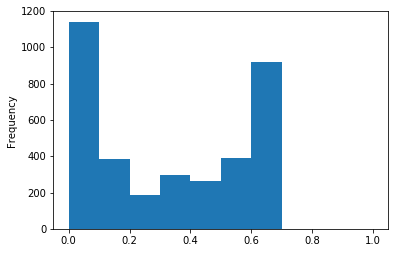

In [131]:
bldf2.occupied.plot.hist()

In [132]:
bldf2['occupied'].quantile([.25,.50,.75])

0.25    0.070175
0.50    0.326316
0.75    0.607018
Name: occupied, dtype: float64

In [124]:
#bldf2['review_agg'].quantile([.25,.5,.75])

In [168]:
#y = bldf2['occupied']
y = bldf2['return']
#X = bldf2.drop(['occupied'],axis=1)
X = bldf2.drop(['return'],axis=1)

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [170]:
reg_lasso = Lasso(alpha=0.1)
reg_lasso.fit(X_train, y_train)
y_preds = reg_lasso.predict(X_test)
r2_score(y_test,y_preds)

-6.0700303552874146e-05

In [171]:
ab_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), random_state=34, n_estimators = 500)
ab_reg.fit(X_train, y_train)
y_preds = ab_reg.predict(X_test)
r2_score(y_test,y_preds)

-2.3045953302755238